# **Laboratorio 12 - Proyecto de Consultoría - SparkML**


- Mónica Salvatierra 22249
- Derek Arreaga 22537

Link del repositorio: https://github.com/alee2602/LAB12-DS

### **Importación de librerías**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, avg, stddev, min as min_, max as max_,
    sum as _sum, when, count, isnan
)
from pyspark.ml.feature import (
    Imputer, VectorAssembler, StandardScaler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA


### **Iniciar sesión en Spark**

In [2]:
spark = (
    SparkSession.builder
    .appName("Análisis de Hackeo")
    .getOrCreate()
)

spark


25/11/02 13:29:53 WARN Utils: Your hostname, DESKTOP-NK707BG resolves to a loopback address: 127.0.1.1; using 172.22.98.149 instead (on interface eth0)
25/11/02 13:29:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/02 13:29:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### **Carga de datos**

In [3]:
df = (
    spark.read.csv(
        "hack_data.csv",
        header=True,
        inferSchema=True
    )
)

df.printSchema()
df.show(5)


root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08

El dataset brindado consiste de **7** columnas con la siguiente descripción:
- ``Session_Connection_Time`` - **double**: 
- ``Bytes Transferred`` - **double**: 
- ``Kali_Trace_Used`` - **integer**: 
- ``Servers_Corrupted`` - **double**: 
- ``Pages_Corrupted`` - **double**:  
- ``Location`` - **string**: Ubicación del ataque 
- ``WPM_Typing_Speed`` - **double**: Velocidad de typeo medido en la cantidad de palabras por minuto

In [5]:
nulls = df.select([
    count(
        when(
            col(c).isNull() | isnan(c) | (col(c) == ""), c
        )
    ).alias(c)
    for c in df.columns
])

nulls.show()



+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+



In [13]:
df.describe().show()


25/11/02 13:30:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       NULL|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       NULL| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

### **Matriz de Correlación**

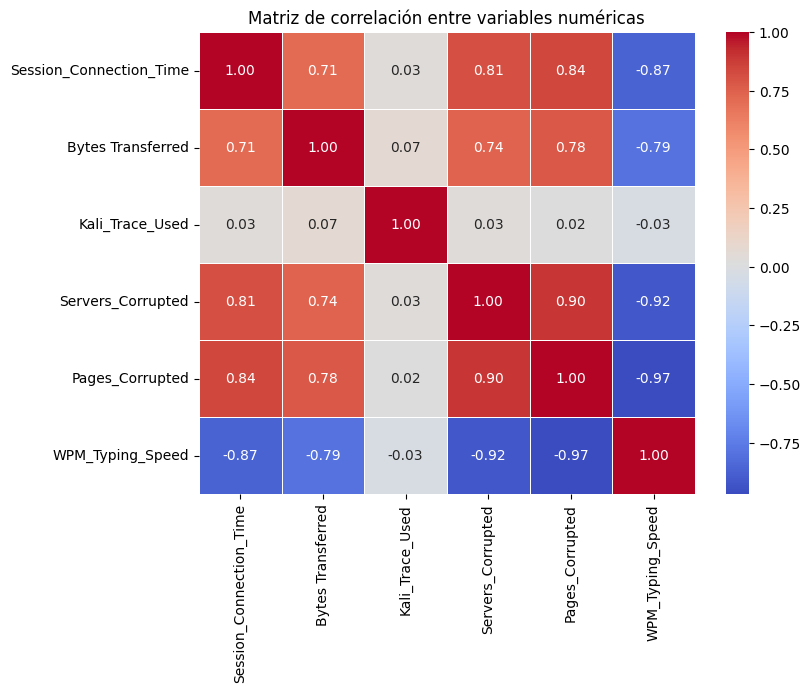

In [4]:
num_cols = ["Session_Connection_Time", "Bytes Transferred", "Kali_Trace_Used", "Servers_Corrupted", "Pages_Corrupted", "WPM_Typing_Speed"]
pdf = df.select(num_cols).toPandas()

corr_matrix = pdf.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

1. Visualizar cantidad de valores nulos y tratarlos de ser necesario
2. Observar las distribuciones de las variables numéricas
3. Codificar la variable de localización
4. Realizar la división de conjuntos para entrenamiento y tests
5. Crear pipeline con el modelo de clustering con K-Means

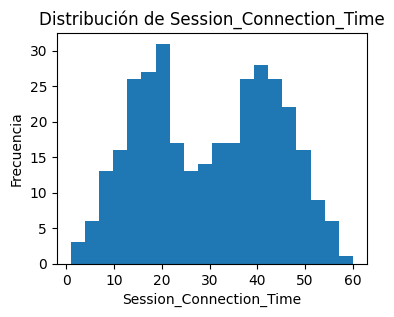

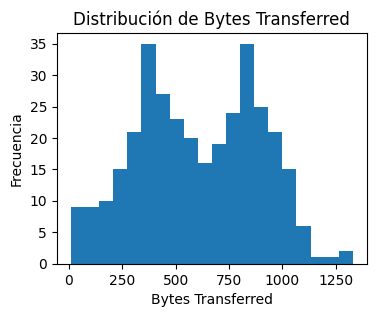

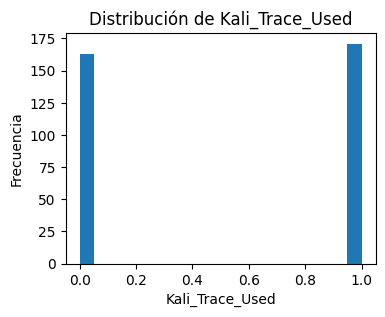

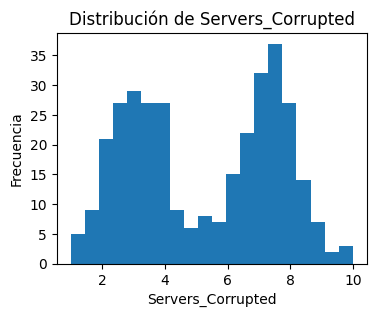

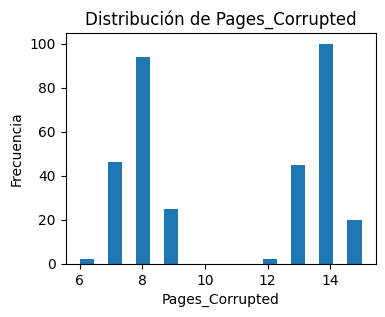

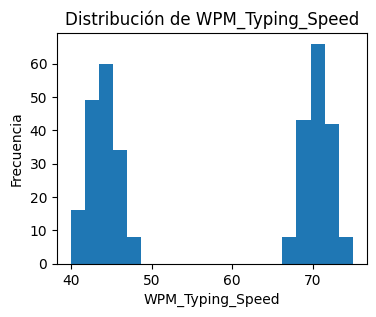

In [6]:
pdf = df.select(num_cols).toPandas()

import matplotlib.pyplot as plt

for col in pdf.columns:
    plt.figure(figsize=(4,3))
    plt.hist(pdf[col], bins=20)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


In [14]:
feature_cols = [
    "Session_Connection_Time",
    "Bytes Transferred",
    "Kali_Trace_Used",
    "Servers_Corrupted",
    "Pages_Corrupted",
    "WPM_Typing_Speed"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_noscaled"
)

df_feats = assembler.transform(df)
df_feats.select("features_noscaled").show(5, truncate=False)


+--------------------------------+
|features_noscaled               |
+--------------------------------+
|[8.0,391.09,1.0,2.96,7.0,72.37] |
|[20.0,720.99,0.0,3.04,9.0,69.08]|
|[31.0,356.32,1.0,3.71,8.0,70.58]|
|[2.0,228.08,1.0,2.48,8.0,70.8]  |
|[20.0,408.5,0.0,3.57,8.0,71.28] |
+--------------------------------+
only showing top 5 rows



In [15]:

scaler = StandardScaler(
    inputCol="features_noscaled",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_feats)
df_scaled = scaler_model.transform(df_feats)

df_scaled.select("features").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------+
|[-1.562228040184432,-0.75490095925522,0.9748653409721156,-0.9985212523861794,-1.2529101889070722,1.1205379005060365]    |
|[-0.7104514131868532,0.3972422527942127,-1.0227114926762684,-0.9637674581126887,-0.6000677503813903,0.8752180545239784] |
|[0.07034382822759382,-0.8763317548992295,0.9748653409721156,-0.6727044310722048,-0.9264889696442312,0.9870660086191414] |
|[-1.9881163536832211,-1.3241973066216277,0.9748653409721156,-1.2070440180271231,-0.9264889696442312,1.0034703752197651] |
|[-0.7104514131868532,-0.6940982513989585,-1.0227114926762684,-0.7335235710508134,-0.9264889696442312,1.0392617205302177]|
+---------------

k=2, cost=601.7707512676687
k=3, cost=434.7550730848759
k=4, cost=267.13361168878936
k=5, cost=248.973058822869
k=6, cost=230.40044634373197
k=7, cost=221.19542695456494
k=8, cost=203.4961972545083


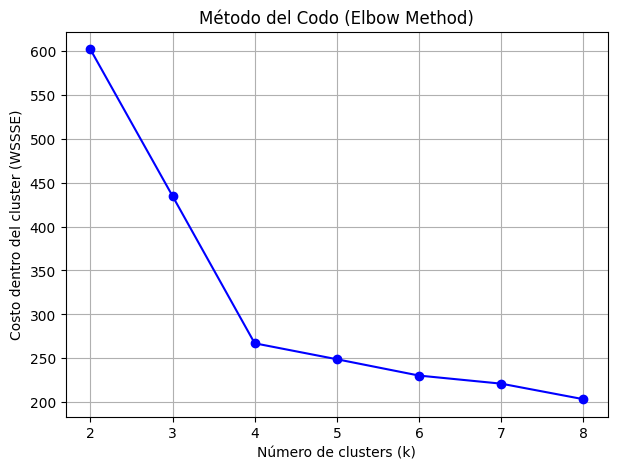

In [19]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Lista de k a probar
ks = list(range(2, 9))
costs = []

# Calcular el costo (WSSSE) para cada k
for k in ks:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    cost = model.summary.trainingCost
    costs.append(cost)
    print(f"k={k}, cost={cost}")

plt.figure(figsize=(7, 5))
plt.plot(ks, costs, marker='o', linestyle='-', color='b')
plt.title('Método del Codo (Elbow Method)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Costo dentro del cluster (WSSSE)')
plt.xticks(ks)
plt.grid(True)
plt.show()


In [24]:
evaluator = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="prediction",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

for k in [2, 3, 4]:
    kmeans = KMeans(
        featuresCol="features",
        predictionCol="prediction",
        k=k,
        seed=42
    )
    model = kmeans.fit(df_scaled)
    result = model.transform(df_scaled)
    
    print(f"\n=== k = {k} ===")
    result.groupBy("prediction").count().show()
    
    sil = evaluator.evaluate(result)
    print("Silhouette:", sil)



=== k = 2 ===
+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+

Silhouette: 0.817646009401246

=== k = 3 ===
+----------+-----+
|prediction|count|
+----------+-----+
|         1|   88|
|         2|   79|
|         0|  167|
+----------+-----+

Silhouette: 0.7608455651454932

=== k = 4 ===
+----------+-----+
|prediction|count|
+----------+-----+
|         1|   79|
|         3|   83|
|         2|   88|
|         0|   84|
+----------+-----+

Silhouette: 0.7195901966635173


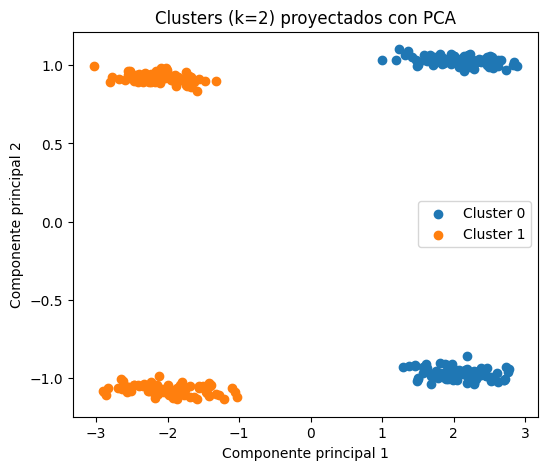

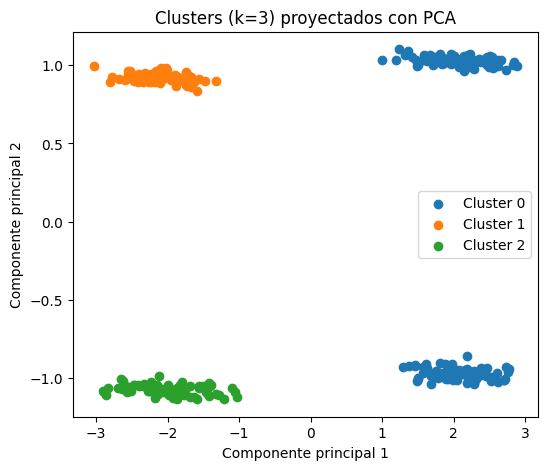

In [22]:

# Reducimos a 2 componentes principales
pca = PCA(k=2, inputCol="features", outputCol="pca2")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

kmeans2 = KMeans(featuresCol="features", k=2, seed=42)
model_k2 = kmeans2.fit(df_scaled)
res_k2 = model_k2.transform(df_pca).select("pca2", "prediction")

kmeans3 = KMeans(featuresCol="features", k=3, seed=42)
model_k3 = kmeans3.fit(df_scaled)
res_k3 = model_k3.transform(df_pca).select("pca2", "prediction")

pdf_k2 = res_k2.toPandas()
pdf_k3 = res_k3.toPandas()

# Función auxiliar para graficar
def plot_clusters(pdf, k):
    x = [vec[0] for vec in pdf["pca2"]]
    y = [vec[1] for vec in pdf["pca2"]]
    labels = pdf["prediction"]

    plt.figure(figsize=(6,5))
    for c in sorted(labels.unique()):
        plt.scatter(
            [x[i] for i in range(len(x)) if labels[i] == c],
            [y[i] for i in range(len(y)) if labels[i] == c],
            label=f"Cluster {c}"
        )
    plt.xlabel("Componente principal 1")
    plt.ylabel("Componente principal 2")
    plt.title(f"Clusters (k={k}) proyectados con PCA")
    plt.legend()
    plt.show()

plot_clusters(pdf_k2, 2)
plot_clusters(pdf_k3, 3)
